<a href="https://colab.research.google.com/github/michiru123/HighD-dataset/blob/master/Github_of_HighDrandomforest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Random Forest Structures using network
Random Forest is a set of multiple decision tree, with the random combination between meaningful features. We can transform this model into a network to investigate  simultanously the contribution of each feature and their correlations. In the network, features is nodes, one edge is formed between 2 features when they both join in a decision tree.

In the optimization stage, Random Forest model just keep features that hold most important roles and these fatures scattered within decision trees. The higher frequency of a feature appears in almost decision trees, the more important of that feature.

Although the importance of a feature can be tested by variable importance, this method could not indicate the correlation between important features: a group of random features will correlate when they are in same decision tree structures. Beside joining randomly, a feature can combine with different features to create the rule for the decision tree, and a feature group appears in multiple trees mean they are important.

In [1]:
from __future__ import print_function
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split 

import numpy as np
import pandas as pd

from numpy import random as nprand
import random
nprand.seed(100)
random.seed(100)

import networkx as nx

import seaborn as sns
from matplotlib import pyplot as plt

plt.rcParams.update({
    'figure.figsize': (15, 15),
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False})

###HighD Dataset
We will use track 45 of HighD Dataset (2000 vehicles) for feature selections among 32 features.

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/michiru123/HighD-dataset/master/track45classed.csv")
df

,Unnamed: 0,id,width,height,initialFrame,finalFrame,numFrames,class,drivingDirection,traveledDistance,minDHW,minTHW,minTTC,min_xVelocity,max_xVelocity,mean_xVelocity,min_yVelocity,max_yVelocity,mean_yVelocity,min_xAcceleration,max_xAcceleration,mean_xAcceleration,min_yAcceleration,max_yAcceleration,mean_yAcceleration,min_frontSightDistance,max_frontSightDistance,min_backSightDistance,max_backSightDistance,min_precedingXVelocity,max_precedingXVelocity,mean_laneId,numLaneChanges
0,0,1,4.24,1.82,1,32,32,1,2,39.51,-1.00,-1.00,-1.00,31.66,32.41,32.03,-0.09,-0.03,-0.06,0.56,0.61,0.60,0.00,0.03,0.02,-1.47,36.13,375.49,413.08,0.00,0.00,6.0,0
1,1,2,4.14,1.82,1,45,45,1,1,65.37,-1.00,-1.00,-1.00,-37.61,-36.77,-37.20,-0.00,0.10,0.04,-0.52,-0.44,-0.48,0.00,0.06,0.04,-0.56,64.07,347.55,412.17,0.00,0.00,4.0,0
2,2,3,17.99,2.50,1,49,49,0,2,50.81,-1.00,-1.00,-1.00,26.25,26.90,26.57,0.18,0.20,0.19,0.29,0.34,0.33,0.00,0.01,0.01,-9.60,39.26,372.36,421.22,0.00,0.00,8.0,0
3,3,4,17.79,2.50,1,51,51,0,2,54.43,-1.00,-1.00,-1.00,26.72,27.93,27.32,0.00,0.03,0.02,0.56,0.62,0.61,0.00,0.01,0.01,-9.80,41.84,369.78,421.42,0.00,0.00,7.0,0
4,4,5,4.85,1.92,1,75,75,1,2,78.64,24.50,0.92,-1.00,25.95,27.40,26.66,-0.07,0.27,0.12,0.40,0.51,0.49,-0.12,-0.01,-0.10,-1.82,75.95,335.67,413.44,0.00,26.90,8.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2444,2444,2445,5.66,2.22,27752,27826,75,1,1,99.90,22.65,0.66,-1.00,-34.29,-33.27,-33.80,-0.12,0.01,-0.05,0.27,0.39,0.34,-0.05,-0.00,-0.04,306.26,406.56,5.05,105.36,-35.03,-34.00,4.0,0
2445,2445,2446,18.39,2.50,27766,27826,61,0,1,65.20,104.94,3.88,23.72,-27.44,-27.00,-27.23,-0.06,-0.00,-0.04,0.15,0.20,0.18,-0.02,0.03,0.01,334.26,400.05,11.57,77.36,-23.48,-22.58,2.0,0
2446,2446,2447,4.04,1.72,27767,27826,60,1,2,74.26,46.37,1.45,217.71,31.09,31.83,31.52,0.00,0.09,0.06,0.21,0.44,0.31,0.00,0.03,0.03,333.65,408.23,3.39,77.97,30.95,31.67,7.0,0
2447,2447,2448,4.85,2.12,27770,27826,57,1,2,73.77,59.16,1.82,-1.00,32.53,33.61,33.05,-0.06,-0.00,-0.03,0.40,0.51,0.49,-0.02,-0.00,-0.02,332.84,406.92,4.70,78.78,34.65,35.98,6.0,0


In [4]:
Xdf = df.drop('numLaneChanges', 1)
#Xdf['class'] = pd.get_dummies(Xdf['class']) #1:Car 0:Truck
Xdf.head()

,Unnamed: 0,id,width,height,initialFrame,finalFrame,numFrames,class,drivingDirection,traveledDistance,minDHW,minTHW,minTTC,min_xVelocity,max_xVelocity,mean_xVelocity,min_yVelocity,max_yVelocity,mean_yVelocity,min_xAcceleration,max_xAcceleration,mean_xAcceleration,min_yAcceleration,max_yAcceleration,mean_yAcceleration,min_frontSightDistance,max_frontSightDistance,min_backSightDistance,max_backSightDistance,min_precedingXVelocity,max_precedingXVelocity,mean_laneId
0,0,1,4.24,1.82,1,32,32,1,2,39.51,-1.0,-1.00,-1.0,31.66,32.41,32.03,-0.09,-0.03,-0.06,0.56,0.61,0.60,0.00,0.03,0.02,-1.47,36.13,375.49,413.08,0.0,0.0,6.0
1,1,2,4.14,1.82,1,45,45,1,1,65.37,-1.0,-1.00,-1.0,-37.61,-36.77,-37.20,-0.00,0.10,0.04,-0.52,-0.44,-0.48,0.00,0.06,0.04,-0.56,64.07,347.55,412.17,0.0,0.0,4.0
2,2,3,17.99,2.50,1,49,49,0,2,50.81,-1.0,-1.00,-1.0,26.25,26.90,26.57,0.18,0.20,0.19,0.29,0.34,0.33,0.00,0.01,0.01,-9.60,39.26,372.36,421.22,0.0,0.0,8.0
3,3,4,17.79,2.50,1,51,51,0,2,54.43,-1.0,-1.00,-1.0,26.72,27.93,27.32,0.00,0.03,0.02,0.56,0.62,0.61,0.00,0.01,0.01,-9.80,41.84,369.78,421.42,0.0,0.0,7.0
4,4,5,4.85,1.92,1,75,75,1,2,78.64,24.5,0.92,-1.0,25.95,27.40,26.66,-0.07,0.27,0.12,0.40,0.51,0.49,-0.12,-0.01,-0.10,-1.82,75.95,335.67,413.44,0.0,26.9,8.0


In [5]:
y = df['numLaneChanges']
features = np.array(Xdf.columns)

Then we create a RandomForest classifier with 500 decision trees in X

In [6]:
clf = RandomForestClassifier(max_depth=5, random_state=0, n_estimators=500)
clf.fit(Xdf, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

These decision tree are saved as estimators_ of model object:

In [7]:
clf.estimators_[0:3]

[DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=5, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=209652396, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=5, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=398764591, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=5, max_feature

each decision tree has data of most important features, and stored in featureimportance.

In [8]:
clf.estimators_[99].feature_importances_

array([0.00207494, 0.        , 0.        , 0.0037153 , 0.        ,
       0.00844254, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01298652, 0.00206756, 0.        , 0.        ,
       0.        , 0.09870714, 0.        , 0.108125  , 0.        ,
       0.00395744, 0.        , 0.11131424, 0.56371084, 0.01208531,
       0.05266602, 0.00204727, 0.00879431, 0.        , 0.00284443,
       0.        , 0.00646113])

We can drop all features with importance score = 0.0, since it doesnt impact on rules of decision tree, the decision tree number 99 has 16 important features.

In [9]:
sum(clf.estimators_[99].feature_importances_ > 0)

16

Then we write a function to transfer info of features importance into a network, the function will receive data as random forest model, with list of features in X, and feature importance threshold as 0.15...

Network was create as a Graph, each time 1 feature appear in 1 decition tree, and have feature importance score higher than the threshold, it will be stored in the network as a node, the number of feature appearance in different decision trees will be culmulated to make "count" feature, the value of feature importance also added up to create feature " score", then feature "avg_vimp" is the average of feature importance = sum of score / sum count. When 2 features are selected in 1 tree, 1 edge between 2 nodes will be created, the number of pairing of these nodes will be written in feature "count" as the weight of edge.

In [10]:
   def random_forest_to_network(rf_mod, features, thres = 0.1):
    
    G = nx.Graph()
    trees = rf_mod.estimators_
    
    for tree in trees:
        vimp_scores = tree.feature_importances_
        vimps = features[vimp_scores > thres]
        scores = vimp_scores[vimp_scores > thres]
        
        for v,s in zip(vimps,scores):
            try:
                G.nodes[v]['count'] += 1
                G.nodes[v]['score'] += s
            except KeyError:
                G.add_node(v)
                G.nodes[v]['count'] = 1
                G.nodes[v]['score'] = s
            for w in vimps:
                try:
                    G.edges[v, w]['count'] += 1
                except KeyError:
                    G.add_edge(v, w, count=1)
    
    for n,d in G.nodes(data = True):
        G.nodes[n]['avg_vimp'] = d['score']/d['count']
    
    return G

We apply the function for RF model and X

In [17]:
features = np.array(Xdf.columns)

G = random_forest_to_network(clf, features, thres = 0.13)

There are 8 features (nodes) written in the network.

In [18]:
len(G.nodes)

8

and 29 pairs

In [19]:
len(G.edges)

29

features of nodes:

In [20]:
G.nodes(data=True)

NodeDataView({'max_yVelocity': {'count': 157, 'score': 52.13907128192921, 'avg_vimp': 0.3320959954263007}, 'mean_yVelocity': {'count': 261, 'score': 99.01475270965436, 'avg_vimp': 0.37936686861936536}, 'mean_yAcceleration': {'count': 30, 'score': 4.847524066807157, 'avg_vimp': 0.16158413556023857}, 'min_yVelocity': {'count': 145, 'score': 50.45992497559794, 'avg_vimp': 0.34799948259033064}, 'max_yAcceleration': {'count': 215, 'score': 89.93426268528175, 'avg_vimp': 0.4182988962106128}, 'min_yAcceleration': {'count': 191, 'score': 81.01771854931519, 'avg_vimp': 0.42417653690740936}, 'mean_laneId': {'count': 6, 'score': 1.9634425573679308, 'avg_vimp': 0.3272404262279885}, 'minDHW': {'count': 1, 'score': 0.16819266793991444, 'avg_vimp': 0.16819266793991444}})

features of edges

In [21]:
G.edges(data =True)

EdgeDataView([('max_yVelocity', 'max_yVelocity', {'count': 157}), ('max_yVelocity', 'mean_yVelocity', {'count': 150}), ('max_yVelocity', 'mean_yAcceleration', {'count': 12}), ('max_yVelocity', 'min_yVelocity', {'count': 92}), ('max_yVelocity', 'max_yAcceleration', {'count': 96}), ('max_yVelocity', 'min_yAcceleration', {'count': 74}), ('max_yVelocity', 'mean_laneId', {'count': 2}), ('mean_yVelocity', 'mean_yVelocity', {'count': 261}), ('mean_yVelocity', 'mean_yAcceleration', {'count': 20}), ('mean_yVelocity', 'max_yAcceleration', {'count': 176}), ('mean_yVelocity', 'min_yAcceleration', {'count': 170}), ('mean_yVelocity', 'min_yVelocity', {'count': 100}), ('mean_yVelocity', 'minDHW', {'count': 2}), ('mean_yAcceleration', 'mean_yAcceleration', {'count': 30}), ('mean_yAcceleration', 'max_yAcceleration', {'count': 24}), ('mean_yAcceleration', 'min_yVelocity', {'count': 16}), ('mean_yAcceleration', 'min_yAcceleration', {'count': 22}), ('min_yVelocity', 'min_yVelocity', {'count': 145}), ('min

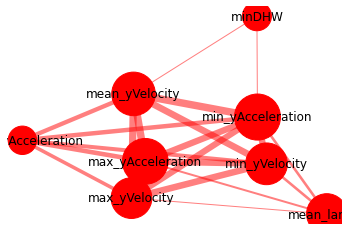

In [22]:
node_sizes = [5000*d['avg_vimp'] for n,d in G.nodes(data = True)]
weights = [np.log2(d['count']) for s, t, d in G.edges(data=True)]

pos=nx.spring_layout(G, k = 0.6)

nx.draw_networkx_nodes(G, pos, alpha=1.0, node_size = node_sizes , node_color = 'red')
nx.draw_networkx_labels(G, pos, font_size = 12, font_color = 'black')
nx.draw_networkx_edges(G, pos, edge_color="red", width = weights, alpha=0.5)

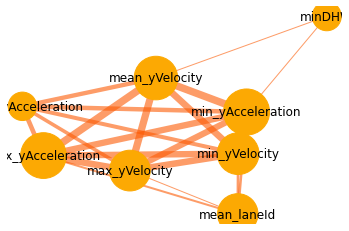

In [23]:
node_sizes = [5000*d['avg_vimp'] for n,d in G.nodes(data = True)]
weights = [np.log2(d['count']) for s, t, d in G.edges(data=True)]

pos=nx.spring_layout(G, k=0.6)

nx.draw_networkx_nodes(G, pos, alpha=1.0, node_size = node_sizes , node_color = '#fca903')
nx.draw_networkx_labels(G, pos, font_size = 12, font_color = 'black')
nx.draw_networkx_edges(G, pos, edge_color='#fc5a03',width = weights, alpha=0.6)